# Discrete hedging experiment for a European Call option under the Heston model

> TODO: Add a description to the experiment

> Under the Heston but we are using the Black-Scholes delta for hedging

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd

from jax import vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','no-latex'])

from jaxfin.models.heston import UnivHestonModel
from jaxfin.price_engine.black_scholes import european_price, delta_european
from jaxfin.price_engine.fft import fourier_inv_call, delta_call_fourier

from src.heston.fourier import fourier_inv_call_1, delta_call
from src.experimental.bs_iv import IV_brent

In [3]:
seed = 42

$$
S(0) = 100 \\
\sigma = 0.2 \\
\mu = 0.00 \\
$$

Let set $N = 252$, which means that we are rebalancing our portfolio daily.

In [4]:
# Initialize the Univariate Heston Model
s0 = 100.0
v0 = 0.04
mean = 0.0
kappa = 1.0
theta = 0.04
sigma = 0.1
rho = -0.7

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)

In [5]:
maturity = 1.0
N = 252
dt = maturity / N
n_sim = 1000

stock_paths, var_process = heston_model.sample_paths(maturity, N, n_sim)

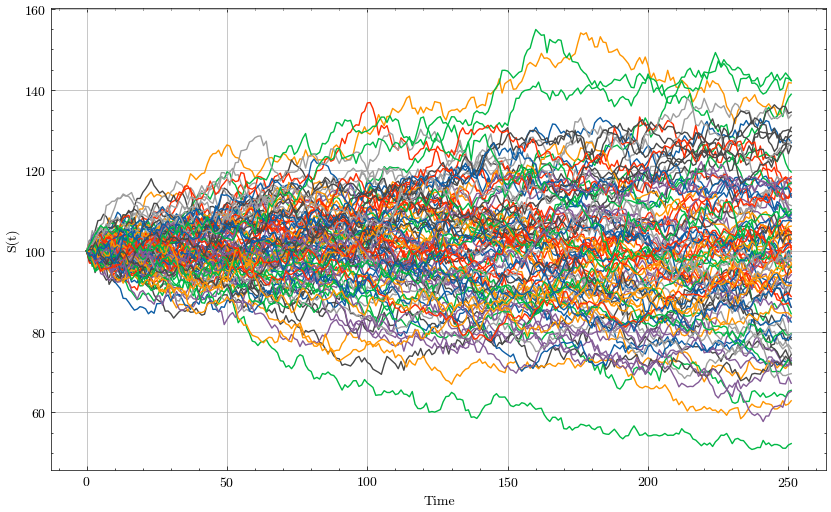

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(stock_paths[:, :100])
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.grid()
plt.show()

In [7]:
discount_rate = 0.0
dividends = 0.0

## Hedging experiment without transaction costs

In [8]:
ticksize = 0.00
K = 100
maturity = 1.0
N = 252
n_sim = 100

v_fourier_delta_call = vmap(delta_call_fourier, in_axes=(0, None, None, None, None, None, None, None, None))
v_fourier_inv_call = vmap(fourier_inv_call, in_axes=(0, None, None, None, None, None, None, None, None))

In [9]:
def get_transaction_costs(ticksize, ddelta):
    return ticksize * (jnp.abs(ddelta) + 0.01 * ddelta**2)

In [10]:
def hedge_experiment_loop(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    deltas = [v_fourier_delta_call(stock_paths[i], K, maturity - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
    cs = [v_fourier_inv_call(stock_paths[i], K, maturity - i * dt, v0, mean, theta, sigma, kappa, rho) for i in range(0, N)]
    b = [cs[0] - deltas[0] * stock_paths[0] - get_transaction_costs(ticksize, deltas[0])]
    vs = [cs[0]]

    for i in range(1, N):
        ddelta = deltas[i] - deltas[i - 1] if i != N - 1 else deltas[i]
        transaction_costs = get_transaction_costs(ticksize, ddelta)
        if i == N - 1:
            transaction_costs += get_transaction_costs(ticksize, deltas[i])

        vs.append(deltas[i - 1] * stock_paths[i] + b[i - 1])
        b.append(vs[i] - deltas[i] * stock_paths[i] - transaction_costs)
        
    hedge_error = jnp.asarray(vs) - jnp.maximum(stock_paths - K, 0)

    return jnp.mean(hedge_error[-1]), jnp.std(hedge_error[-1]) / jnp.asarray(cs)[0, 0]

### Experiments

In [11]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [12]:
def update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=0.00):
    mean_hedge_error, std_hedge_error = hedge_experiment_loop(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

    results['Strike'].append(K)
    results['Sigma'].append(sigma)
    results['Maturity'].append(maturity)
    results['Rebalancing_freq'].append(N)
    results['E_PL_T'].append(mean_hedge_error)
    results['Std_PL_T'].append(std_hedge_error)

    print(f'The mean hedge error is: {mean_hedge_error}')
    print(f'The normalized std of the hedge error is: {std_hedge_error}')

    return results

In [13]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.005910124164074659
The normalized std of the hedge error is: 0.1188233271241188


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [14]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [15]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.025689134374260902
The normalized std of the hedge error is: 0.02985571324825287


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [16]:
K = 90

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [17]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.02921273559331894
The normalized std of the hedge error is: 0.061201974749565125


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [18]:
K = 110

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [19]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.04710788652300835
The normalized std of the hedge error is: 0.22129540145397186


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [20]:
K = 120

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [21]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.03650705888867378
The normalized std of the hedge error is: 0.44959619641304016


#### Different maturities with daily rebalancing

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.75 \quad n = 252
$$

In [22]:
K = 100
T = 0.75
N = 252

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [23]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.25 \quad n = 252
$$

In [24]:
T = 1.25

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [25]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.8226381540298462
The normalized std of the hedge error is: 0.1417711228132248


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.00 \quad n = 252
$$

In [26]:
T = 2.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [27]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 3.2917468547821045
The normalized std of the hedge error is: 0.23390503227710724


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [28]:
K = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [29]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.07647626101970673
The normalized std of the hedge error is: 0.2277468889951706


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [30]:
K = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [31]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.042512502521276474
The normalized std of the hedge error is: 0.2730308771133423


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [32]:
N = 121
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [33]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.20247992873191833
The normalized std of the hedge error is: 0.22667653858661652


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 504
$$

In [34]:
N = 504
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [35]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [36]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.00,252,0.005910124,0.11882333
1,80,0.1,1.00,252,-0.025689134,0.029855713
2,90,0.1,1.00,252,0.029212736,0.061201975
3,110,0.1,1.00,252,-0.047107887,0.2212954
4,120,0.1,1.00,252,-0.03650706,0.4495962
5,100,0.1,0.75,252,nan,nan
6,100,0.1,1.25,252,0.82263815,0.14177112
7,100,0.1,2.00,252,3.2917469,0.23390503
8,100,0.2,1.00,252,0.07647626,0.22774689
9,100,0.1,1.00,52,-0.042512503,0.27303088


In [37]:
res_df.to_csv('./results/heston_delta_zero.csv')

### Hedging experiments with low transcation costs

### Experiments

In [38]:
ticksize = 0.01
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [39]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [40]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.15401312708854675
The normalized std of the hedge error is: 0.11090155690908432


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [41]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [42]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.016601085662841797
The normalized std of the hedge error is: 0.02450917288661003


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [43]:
K = 90

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [44]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: 0.0064214919693768024
The normalized std of the hedge error is: 0.05255887657403946


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [45]:
K = 110

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [46]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.022107111290097237
The normalized std of the hedge error is: 0.2447436898946762


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [47]:
K = 120

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [48]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.025881895795464516
The normalized std of the hedge error is: 0.4652826488018036


#### Different maturities with daily rebalancing

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.75 \quad n = 252
$$

In [49]:
K = 100
T = 0.75
N = 252

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [50]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.25 \quad n = 252
$$

In [51]:
T = 1.25

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [52]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.6810153722763062
The normalized std of the hedge error is: 0.15940192341804504


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.00 \quad n = 252
$$

In [53]:
T = 2.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [54]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 2.968575954437256
The normalized std of the hedge error is: 0.23471014201641083


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [55]:
K = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [56]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.31906700134277344
The normalized std of the hedge error is: 0.2365221530199051


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [57]:
K = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [58]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.01077607087790966
The normalized std of the hedge error is: 0.2797304093837738


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [59]:
N = 121
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [60]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.016629504039883614
The normalized std of the hedge error is: 0.2064296454191208


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 504
$$

In [61]:
N = 504
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [62]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [63]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.00,252,-0.15401313,0.11090156
1,80,0.1,1.00,252,0.016601086,0.024509173
2,90,0.1,1.00,252,0.006421492,0.052558877
3,110,0.1,1.00,252,-0.022107111,0.24474369
4,120,0.1,1.00,252,-0.025881896,0.46528265
5,100,0.1,0.75,252,nan,nan
6,100,0.1,1.25,252,0.6810154,0.15940192
7,100,0.1,2.00,252,2.968576,0.23471014
8,100,0.2,1.00,252,-0.319067,0.23652215
9,100,0.1,1.00,52,0.010776071,0.2797304


In [64]:
res_df.to_csv('./results/c_delta_low.csv')

### Hedging experiments with high transcation costs

### Experiments

In [65]:
ticksize = 0.05
K = 100
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [66]:
results = {
    'Strike': [],
    'Sigma': [],
    'Maturity': [],
    'Rebalancing_freq': [],
    'E_PL_T': [],
    'Std_PL_T': []
}

In [67]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.38470765948295593
The normalized std of the hedge error is: 0.13226832449436188


#### Different strike prices

$$
S_0 = 100 \quad K = 80 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [68]:
K = 80
sigma = 0.1
maturity = 1.0
N = 252
n_sim = 100

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [69]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.2184256762266159
The normalized std of the hedge error is: 0.03759733587503433


$$
S_0 = 100 \quad K = 90 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [70]:
K = 90

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [71]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.2966834008693695
The normalized std of the hedge error is: 0.07152651250362396


$$
S_0 = 100 \quad K = 110 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [72]:
K = 110

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [73]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.14013947546482086
The normalized std of the hedge error is: 0.20491084456443787


$$
S_0 = 100 \quad K = 120 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 252
$$

In [74]:
K = 120

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [75]:
results = update_results(stock_paths, K, discount_rate, sigma, maturity, N, ticksize=ticksize)

The mean hedge error is: -0.32896584272384644
The normalized std of the hedge error is: 0.4819125831127167


#### Different maturities with daily rebalancing

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 0.75 \quad n = 252
$$

In [76]:
K = 100
T = 0.75
N = 252

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [77]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.25 \quad n = 252
$$

In [78]:
T = 1.25

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [79]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.8376139402389526
The normalized std of the hedge error is: 0.1827627420425415


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 2.00 \quad n = 252
$$

In [80]:
T = 2.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [81]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 2.6632399559020996
The normalized std of the hedge error is: 0.22076158225536346


#### Different volatilities

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.1 \quad T = 1.0 \quad n = 252
$$

In [82]:
K = 100
T = 1.0
N = 252
sigma = 0.2

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [83]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.30506518483161926
The normalized std of the hedge error is: 0.2154768407344818


### Different Rebalancing periods

$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 52
$$

In [84]:
K = 100
sigma = 0.1
N = 52
T = 1.0

heston_model = UnivHestonModel(s0, v0, mean, kappa, theta, sigma, rho)
stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [85]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: 0.014674333855509758
The normalized std of the hedge error is: 0.2899598777294159


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 121
$$

In [86]:
N = 121
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [87]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: -0.4100440740585327
The normalized std of the hedge error is: 0.22257384657859802


$$
S_0 = 100 \quad K = 100 \quad \sigma = 0.2 \quad T = 1.0 \quad n = 504
$$

In [88]:
N = 504
T = 1.0

stock_paths, _ = heston_model.sample_paths(maturity, N, n_sim)

In [89]:
results = update_results(stock_paths, K, discount_rate, sigma, T, N, ticksize=ticksize)

The mean hedge error is: nan
The normalized std of the hedge error is: nan


In [90]:
res_df = pd.DataFrame.from_dict(results)
res_df

,Strike,Sigma,Maturity,Rebalancing_freq,E_PL_T,Std_PL_T
0,100,0.1,1.00,252,-0.38470766,0.13226832
1,80,0.1,1.00,252,-0.21842568,0.037597336
2,90,0.1,1.00,252,-0.2966834,0.07152651
3,110,0.1,1.00,252,-0.14013948,0.20491084
4,120,0.1,1.00,252,-0.32896584,0.48191258
5,100,0.1,0.75,252,nan,nan
6,100,0.1,1.25,252,0.83761394,0.18276274
7,100,0.1,2.00,252,2.66324,0.22076158
8,100,0.2,1.00,252,-0.30506518,0.21547684
9,100,0.1,1.00,52,0.014674334,0.28995988


In [91]:
res_df.to_csv('./results/heston_delta_high.csv')